In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('abc').config("spark.jars.packages", "com.microsoft.ml.spark:mmlspark_2.11:1.0.0-rc1").config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven").getOrCreate()
spark

## This notebook built a ml model to predict industry according to the financial performance
### read in the dataset and print schema

In [6]:
df = spark.read.parquet('s3://sec-finc/pivot_data_vfinal/')
df.printSchema()
df = df.na.drop(subset=['NetIncomeLoss'])

root
 |-- company_name: string (nullable = true)
 |-- assigned_sic: integer (nullable = true)
 |-- document_fiscal_year_focus: integer (nullable = true)
 |-- CostOfGoodsAndServicesSold: double (nullable = true)
 |-- CostOfGoodsSold: double (nullable = true)
 |-- CostOfServices: double (nullable = true)
 |-- EarningsPerShareBasic: double (nullable = true)
 |-- EarningsPerShareDiluted: double (nullable = true)
 |-- GainLossOnDispositionOfAssets: double (nullable = true)
 |-- GeneralAndAdministrativeExpense: double (nullable = true)
 |-- IncomeTaxesPaid: double (nullable = true)
 |-- IncreaseDecreaseInAccountsPayable: double (nullable = true)
 |-- IncreaseDecreaseInAccountsReceivable: double (nullable = true)
 |-- IncreaseDecreaseInAccruedLiabilities: double (nullable = true)
 |-- IncreaseDecreaseInInventories: double (nullable = true)
 |-- LaborAndRelatedExpense: double (nullable = true)
 |-- NetCashProvidedByUsedInFinancingActivities: double (nullable = true)
 |-- NetCashProvidedByUsedI

### fill missing value

In [7]:
from pyspark.sql.functions import isnan, count, when, col, isnull
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()
df = df.na.fill(0)

+------------+------------+--------------------------+--------------------------+---------------+--------------+---------------------+-----------------------+-----------------------------+-------------------------------+---------------+---------------------------------+------------------------------------+------------------------------------+-----------------------------+----------------------+------------------------------------------+--------------------------------------------------------------+------------------------------------------+--------------------------------------------------------------+------------------------------------------+--------------------------------------------------------------+-------------+-----------------+-------------------+----------------------------------+-------------------+------------------------------+------------------------+--------------------------------------------+------------------------------------------+------------------------+---------

The Standard Industrial Classification (SIC) is a system for classifying industries by a four-digit code.
There are 10 sectors of industry. For simplification, we categorized them into 2 groups: *1). agriculture and manufacturing, and 2). sales and services.* The first group includes Agriculture, Forestry and Fishing; Mining; Construction; Manufacturing; Transportation, Communications, Electric, Gas and Sanitary service. The second group contains Wholesale Trade; Retail Trade; Finance, Insurance and Real Estate; Services; Public Administration.

In [118]:
df.createOrReplaceTempView("dfTable")
inc = spark.sql('''
select *, CASE \
    when assigned_sic >=100 and assigned_sic<5000 then 1 \
    when assigned_sic>=5000 then 2 \
    else null end as industry_label from dfTable
''')

### add the label

In [119]:
from pyspark.sql.types import *
inc = inc.withColumn("industry_label", inc["industry_label"].cast(StringType()))

In [120]:
inc.select("industry_label").groupby("industry_label").count().show()

+--------------+-----+
|industry_label|count|
+--------------+-----+
|          null|    9|
|             1|17448|
|             2|17271|
+--------------+-----+



### drop where response is missing

In [121]:
inc = inc.na.drop(subset=['industry_label'])

In [122]:
inc.dtypes

[('company_name', 'string'),
 ('assigned_sic', 'int'),
 ('document_fiscal_year_focus', 'int'),
 ('CostOfGoodsAndServicesSold', 'double'),
 ('CostOfGoodsSold', 'double'),
 ('CostOfServices', 'double'),
 ('EarningsPerShareBasic', 'double'),
 ('EarningsPerShareDiluted', 'double'),
 ('GainLossOnDispositionOfAssets', 'double'),
 ('GeneralAndAdministrativeExpense', 'double'),
 ('IncomeTaxesPaid', 'double'),
 ('IncreaseDecreaseInAccountsPayable', 'double'),
 ('IncreaseDecreaseInAccountsReceivable', 'double'),
 ('IncreaseDecreaseInAccruedLiabilities', 'double'),
 ('IncreaseDecreaseInInventories', 'double'),
 ('LaborAndRelatedExpense', 'double'),
 ('NetCashProvidedByUsedInFinancingActivities', 'double'),
 ('NetCashProvidedByUsedInFinancingActivitiesContinuingOperations', 'double'),
 ('NetCashProvidedByUsedInInvestingActivities', 'double'),
 ('NetCashProvidedByUsedInInvestingActivitiesContinuingOperations', 'double'),
 ('NetCashProvidedByUsedInOperatingActivities', 'double'),
 ('NetCashProvidedB

### encode categorical variable to numerical

In [123]:
from pyspark.ml.feature import VectorAssembler,StringIndexer, IndexToString
# convert stings to numerical
indexer1 = StringIndexer(inputCol="industry_label", outputCol="industry_label_n",handleInvalid="skip")

In [134]:
numericCols = ['CostOfGoodsAndServicesSold', 'CostOfGoodsSold', 'CostOfServices', 'EarningsPerShareBasic', 
               'EarningsPerShareDiluted', 'GainLossOnDispositionOfAssets', 'GeneralAndAdministrativeExpense', 
               'IncomeTaxesPaid', 'IncreaseDecreaseInAccountsPayable', 'IncreaseDecreaseInAccountsReceivable', 
               'IncreaseDecreaseInAccruedLiabilities', 'IncreaseDecreaseInInventories', 
               'LaborAndRelatedExpense', 'NetCashProvidedByUsedInFinancingActivities', 
               'NetCashProvidedByUsedInFinancingActivitiesContinuingOperations', 
               'NetCashProvidedByUsedInInvestingActivities', 'NetCashProvidedByUsedInInvestingActivitiesContinuingOperations', 
               'NetCashProvidedByUsedInOperatingActivities', 'NetCashProvidedByUsedInOperatingActivitiesContinuingOperations', 
               'NetIncomeLoss', 'OperatingExpenses', 'OperatingIncomeLoss', 'PaymentsForRepurchaseOfCommonStock', 
               'PaymentsOfDividends', 'PaymentsOfDividendsCommonStock', 'PaymentsOfFinancingCosts', 'PaymentsToAcquireBusinessesNetOfCashAcquired', 
               'PaymentsToAcquirePropertyPlantAndEquipment', 'RepaymentsOfLongTermDebt', 'ResearchAndDevelopmentExpense', 
               'Revenues', 'SellingAndMarketingExpense', 'ShareBasedCompensation']

assembler = VectorAssembler(inputCols=numericCols, outputCol="features1", handleInvalid="keep")

### build ml pipeline

In [136]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[indexer1,assembler])

pipelineModel = pipeline.fit(inc)

Cols = ['industry_label_n','CostOfGoodsAndServicesSold', 'CostOfGoodsSold', 'CostOfServices', 'EarningsPerShareBasic', 
               'EarningsPerShareDiluted', 'GainLossOnDispositionOfAssets', 'GeneralAndAdministrativeExpense', 
               'IncomeTaxesPaid', 'IncreaseDecreaseInAccountsPayable', 'IncreaseDecreaseInAccountsReceivable', 
               'IncreaseDecreaseInAccruedLiabilities', 'IncreaseDecreaseInInventories', 
               'LaborAndRelatedExpense', 'NetCashProvidedByUsedInFinancingActivities', 
               'NetCashProvidedByUsedInFinancingActivitiesContinuingOperations', 
               'NetCashProvidedByUsedInInvestingActivities', 'NetCashProvidedByUsedInInvestingActivitiesContinuingOperations', 
               'NetCashProvidedByUsedInOperatingActivities', 'NetCashProvidedByUsedInOperatingActivitiesContinuingOperations', 
               'NetIncomeLoss', 'OperatingExpenses', 'OperatingIncomeLoss', 'PaymentsForRepurchaseOfCommonStock', 
               'PaymentsOfDividends', 'PaymentsOfDividendsCommonStock', 'PaymentsOfFinancingCosts', 'PaymentsToAcquireBusinessesNetOfCashAcquired', 
               'PaymentsToAcquirePropertyPlantAndEquipment', 'RepaymentsOfLongTermDebt', 'ResearchAndDevelopmentExpense', 
               'Revenues', 'SellingAndMarketingExpense', 'ShareBasedCompensation']

inc = pipelineModel.transform(inc)
selectedCols = ['features1'] + Cols
inc = inc.select(selectedCols)
inc.printSchema()

root
 |-- features1: vector (nullable = true)
 |-- industry_label_n: double (nullable = false)
 |-- CostOfGoodsAndServicesSold: double (nullable = false)
 |-- CostOfGoodsSold: double (nullable = false)
 |-- CostOfServices: double (nullable = false)
 |-- EarningsPerShareBasic: double (nullable = false)
 |-- EarningsPerShareDiluted: double (nullable = false)
 |-- GainLossOnDispositionOfAssets: double (nullable = false)
 |-- GeneralAndAdministrativeExpense: double (nullable = false)
 |-- IncomeTaxesPaid: double (nullable = false)
 |-- IncreaseDecreaseInAccountsPayable: double (nullable = false)
 |-- IncreaseDecreaseInAccountsReceivable: double (nullable = false)
 |-- IncreaseDecreaseInAccruedLiabilities: double (nullable = false)
 |-- IncreaseDecreaseInInventories: double (nullable = false)
 |-- LaborAndRelatedExpense: double (nullable = false)
 |-- NetCashProvidedByUsedInFinancingActivities: double (nullable = false)
 |-- NetCashProvidedByUsedInFinancingActivitiesContinuingOperations: do

In [137]:
import mmlspark

lgbClassifier = LightGBMClassifier(learningRate=0.3,
                           numIterations=100,
                           numLeaves=31, featuresCol='features1',labelCol='industry_label_n')

train, test = inc.randomSplit([0.85, 0.15], seed=1)
lgbClassifierModel = lgbClassifier.fit(train)
test_class = lgbClassifierModel.transform(test)

### see the convert the label to original string type

In [141]:
converter = IndexToString(inputCol="industry_label_n", outputCol="originalCategory")
converted = converter.transform(inc)

In [144]:
converted.select("industry_label_n", "originalCategory").distinct().show()

+----------------+----------------+
|industry_label_n|originalCategory|
+----------------+----------------+
|             1.0|               2|
|             0.0|               1|
+----------------+----------------+



label 0 represents industry "2" while label 0 represents industry "1"

### Evaluation
areaUnderROC

In [63]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator as bce
evaluator = bce(rawPredictionCol='probability', labelCol='industry_label_n')
print(evaluator.evaluate(test_class, {evaluator.metricName: 'areaUnderROC'}))

0.917395279451731


In [65]:
from sklearn.metrics import classification_report, confusion_matrix
y_true = test_class.select(['industry_label_n']).collect()
y_pred = test_class.select(['prediction']).collect()
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.85      0.84      2604
         1.0       0.85      0.82      0.83      2600

    accuracy                           0.83      5204
   macro avg       0.83      0.83      0.83      5204
weighted avg       0.83      0.83      0.83      5204



In [66]:
confusion_matrix(y_true, y_pred, labels=[0, 1])

array([[2222,  382],
       [ 480, 2120]])

### Plot the feature importance

In [85]:
import pandas as pd
features=['CostOfGoodsAndServicesSold', 'CostOfGoodsSold', 'CostOfServices', 'EarningsPerShareBasic', 
               'EarningsPerShareDiluted', 'GainLossOnDispositionOfAssets', 'GeneralAndAdministrativeExpense', 
               'IncomeTaxesPaid', 'IncreaseDecreaseInAccountsPayable', 'IncreaseDecreaseInAccountsReceivable', 
               'IncreaseDecreaseInAccruedLiabilities', 'IncreaseDecreaseInInventories', 
               'LaborAndRelatedExpense', 'NetCashProvidedByUsedInFinancingActivities', 
               'NetCashProvidedByUsedInFinancingActivitiesContinuingOperations', 
               'NetCashProvidedByUsedInInvestingActivities', 'NetCashProvidedByUsedInInvestingActivitiesContinuingOperations', 
               'NetCashProvidedByUsedInOperatingActivities', 'NetCashProvidedByUsedInOperatingActivitiesContinuingOperations', 
               'NetIncomeLoss', 'OperatingExpenses', 'OperatingIncomeLoss', 'PaymentsForRepurchaseOfCommonStock', 
               'PaymentsOfDividends', 'PaymentsOfDividendsCommonStock', 'PaymentsOfFinancingCosts', 'PaymentsToAcquireBusinessesNetOfCashAcquired', 
               'PaymentsToAcquirePropertyPlantAndEquipment', 'RepaymentsOfLongTermDebt', 'ResearchAndDevelopmentExpense', 
               'Revenues', 'SellingAndMarketingExpense', 'ShareBasedCompensation']
importance = lgbClassifierModel.getFeatureImportances()
imp = pd.DataFrame()
imp['feature'] = features
imp['importance']=importance

In [90]:
imp = imp.sort_values(by='importance', ascending=0)
imp = imp.reset_index(drop = True)
imp = imp[0:10]
imp

,feature,importance
0,PaymentsToAcquirePropertyPlantAndEquipment,202.0
1,OperatingIncomeLoss,200.0
2,ShareBasedCompensation,172.0
3,NetIncomeLoss,153.0
4,IncreaseDecreaseInAccountsReceivable,149.0
5,GeneralAndAdministrativeExpense,146.0
6,IncreaseDecreaseInInventories,143.0
7,Revenues,134.0
8,OperatingExpenses,116.0
9,NetCashProvidedByUsedInOperatingActivities,111.0


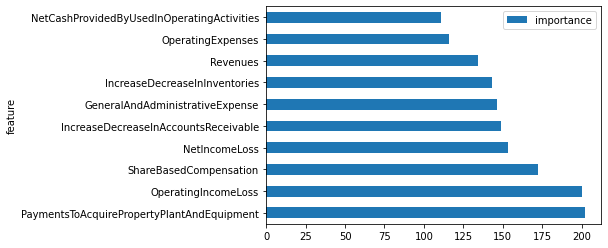

In [91]:
from matplotlib import pyplot as plt
import numpy as np
imp.plot(kind='barh',x='feature',y='importance')

### compare the difference in the most important features between the two groups
detailed analyses please see the report

In [107]:
inc.createOrReplaceTempView("inc")
top10 = spark.sql('''
select PaymentsToAcquirePropertyPlantAndEquipment,
OperatingIncomeLoss,
ShareBasedCompensation,
NetIncomeLoss,
IncreaseDecreaseInAccountsReceivable,
GeneralAndAdministrativeExpense,
IncreaseDecreaseInInventories,
Revenues,
OperatingExpenses,
NetCashProvidedByUsedInOperatingActivities,
industry_label_n
from inc
''')

In [114]:
top10[top10['industry_label_n']==1].mean(axis = 0)

PaymentsToAcquirePropertyPlantAndEquipment    1.747440e+08
OperatingIncomeLoss                           1.961909e+08
ShareBasedCompensation                        1.891467e+07
NetIncomeLoss                                 8.128655e+08
IncreaseDecreaseInAccountsReceivable          8.036808e+06
GeneralAndAdministrativeExpense               1.617463e+08
IncreaseDecreaseInInventories                -1.922402e+06
Revenues                                      1.966043e+09
OperatingExpenses                             1.738115e+08
NetCashProvidedByUsedInOperatingActivities    9.838758e+08
industry_label_n                              1.000000e+00
dtype: float64

In [116]:
top10[top10['industry_label_n']==0].mean(axis = 0)

PaymentsToAcquirePropertyPlantAndEquipment    6.601431e+08
OperatingIncomeLoss                           1.068636e+09
ShareBasedCompensation                        1.335568e+07
NetIncomeLoss                                 8.773825e+08
IncreaseDecreaseInAccountsReceivable          3.391371e+07
GeneralAndAdministrativeExpense               2.407248e+07
IncreaseDecreaseInInventories                 8.529190e+07
Revenues                                      8.762541e+09
OperatingExpenses                             1.069280e+09
NetCashProvidedByUsedInOperatingActivities    1.816322e+09
industry_label_n                              0.000000e+00
dtype: float64